# STATS 231A Homework 4 - Candace McKeag

*** DISCLAIMER TO THE GRADER ***

Even using Google Colab, training time was very long for the GANs and the Translators. I had to make the decision to use less training data and perform fewer training epochs in order to get my results in a reasonable amount of time. Because of this, my results (loss values, predictions, etc.) may be of lower quality or different from the blogs'/other students'.

# Environment Setup

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
import imageio
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display
from abc import ABC
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import unicodedata
import re
import io

In [2]:
print(tf.__version__)

2.3.0


In [ ]:
#!pip install -q imageio
#!pip install -q git+https://github.com/tensorflow/docs

# Problem 0: Intro

Read about Google Colab:

https://colab.research.google.com/notebooks/intro.ipynb

Read about TensorFlow: 

https://www.tensorflow.org

# Problem 1: Classification

Play with the code: https://www.tensorflow.org/tutorials/keras/classification.

## (1)

Write a memo for the code, annotating some important lines that carry out key computations.

In [3]:
# import the fashion mnist dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_fashion_images, train_fashion_labels), (test_fashion_images, test_fashion_labels) = fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# preprocess the data
# Scale these values to a range of 0 to 1 before feeding them to the neural network model
train_fashion_images = train_fashion_images / 255.0
test_fashion_images = test_fashion_images / 255.0

4423680/4422102 [==============================] - 0s 0us/step


In [4]:
class Classification:
    """
    Trains a neural network model to classify images.

    Methods
    -------
    plot_image(i, predictions_array, true_label, img):
        Utility method for plotting image.
    plot_value_array(i, predictions_array, true_label):
        Utility method to plot array of values.
    train(self):
        Builds, compiles, trains, and evaluates a Sequential neural network.
    predict(self, model):
        Makes predictions on test images and plots an array of predicted labels and the true images.
    """

    def __init__(self, train_images, train_labels, test_images, test_labels, activation='relu', num_nodes1=128,
                 add_layer=False):
        """
        Constructs all the necessary attributes for the Classification object.
        :param train_images: images to train on
        :param train_labels: training labels
        :param test_images: images to test on
        :param test_labels: testing labels
        :param activation: activation function to use (e.g., relu, sigmoid, linear, softmax...)
        :param num_nodes1: number of nodes in first dense layer
        :param add_layer: whether or not to add another dense layer
        """
        self.train_images = train_images
        self.train_labels = train_labels
        self.test_images = test_images
        self.test_labels = test_labels
        self.activation = activation
        self.num_nodes1 = num_nodes1
        self.add_layer = add_layer

    def __call__(self):
        """

        :return:
        """
        model = self.train()
        self.predict(model)

    @staticmethod
    def plot_image(i, predictions_array, true_label, img):
        """
        Utility method for plotting image.
        :param i: index of image
        :param predictions_array: array of predictions for image
        :param true_label: true labels of all images
        :param img: all test images
        :return: nothing
        """
        # select i'th image from all test images and all true labels
        true_label, img = true_label[i], img[i]
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])

        plt.imshow(img, cmap=plt.cm.binary)

        predicted_label = np.argmax(predictions_array)
        if predicted_label == true_label:
            # BLUE IS RIGHT
            color = 'blue'
        else:
            # RED IS WRONG
            color = 'red'

        plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                             100 * np.max(predictions_array),
                                             class_names[true_label]),
                   color=color)

    @staticmethod
    def plot_value_array(i, predictions_array, true_label):
        """
        Utility method to plot array of values.
        :param i: index of image
        :param predictions_array: array of predictions for image
        :param true_label: true image label
        :return: nothing
        """
        true_label = true_label[i]
        plt.grid(False)
        plt.xticks(range(10))
        plt.yticks([])
        thisplot = plt.bar(range(10), predictions_array, color="#777777")
        plt.ylim([0, 1])
        predicted_label = np.argmax(predictions_array)

        thisplot[predicted_label].set_color('red')
        thisplot[true_label].set_color('blue')

    def train(self):
        """
        Builds, compiles, trains, and evaluates a Sequential neural network.
        :return: model that is trained and evaluated
        """
        # build and compile the model
        # chaining together simple layers
        # if want to add another dense layer
        if self.add_layer:
            model = tf.keras.Sequential([
                # transforms the format of the images from a two-dimensional array to a one-dimensional array
                tf.keras.layers.Flatten(input_shape=(28, 28)),
                # three fully connected layers
                tf.keras.layers.Dense(self.num_nodes1, activation=self.activation),
                tf.keras.layers.Dense(64, activation=self.activation),
                tf.keras.layers.Dense(10)
            ])
        # if not adding another dense layer
        else:
            model = tf.keras.Sequential([
                # transforms the format of the images from a two-dimensional array to a one-dimensional array
                tf.keras.layers.Flatten(input_shape=(28, 28)),
                # two fully connected layers
                tf.keras.layers.Dense(self.num_nodes1, activation=self.activation),
                tf.keras.layers.Dense(10)
            ])

        # compile step
        # optimizer: how the model is updated based on the data it sees and its loss function
        # loss: measures how accurate the model is during training
        # metrics: used to monitor the training and testing steps
        model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])

        # train the model
        # feeds the training data, model learns to associate images and labels,
        # ask the model to make predictions about a test set, verify that the predictions match the labels
        model.fit(self.train_images, self.train_labels, epochs=10)

        # evaluate
        # compare how the model performs on the test dataset
        test_loss, test_acc = model.evaluate(self.test_images, self.test_labels, verbose=2)
        print('\nTest accuracy:', test_acc)

        return model

    def predict(self, model):
        """
        Makes predictions on test images and plots an array of predicted labels and the true images.
        :param model: model trained with train() method
        :return: nothing
        """
        # make predictions
        # attach a softmax layer to convert the logits to probabilities, which are easier to interpret
        probability_model = tf.keras.Sequential([model,
                                                 tf.keras.layers.Softmax()])
        predictions = probability_model.predict(self.test_images)

        # Plot the first X test images, their predicted labels, and the true labels.
        # Color correct predictions in blue and incorrect predictions in red.
        num_rows = 5
        num_cols = 3
        num_images = num_rows * num_cols
        plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
        for i in range(num_images):
            plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
            self.plot_image(i, predictions[i], self.test_labels, self.test_images)
            plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
            self.plot_value_array(i, predictions[i], self.test_labels)
        plt.tight_layout()
        plt.show()

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5014 - accuracy: 0.8246
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3765 - accuracy: 0.8650
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3387 - accuracy: 0.8766
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3155 - accuracy: 0.8844
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2971 - accuracy: 0.8903
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2838 - accuracy: 0.8957
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2693 - accuracy: 0.9005
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2576 - accuracy: 0.9040
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2484 - accuracy: 0.9078
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.238

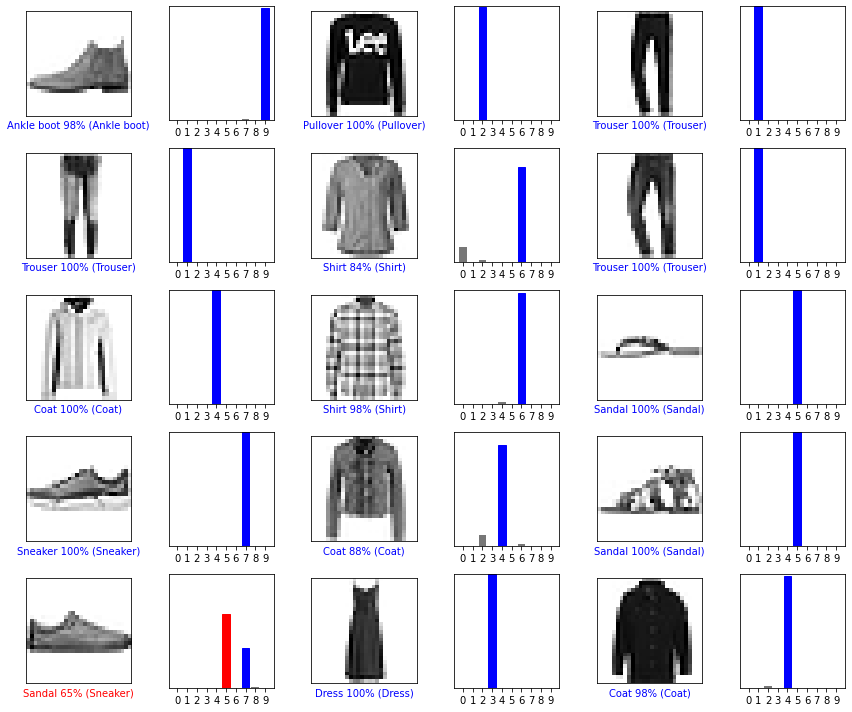

In [5]:
classification_1 = Classification(train_fashion_images, train_fashion_labels,
                                  test_fashion_images, test_fashion_labels)
classification_1()

## (2)

Vary the model architecture, e.g., adding a layer, changing the number of channels in CNN, or the dimension of the hidden vector in RNN, and report the results.

Using the `Classification` object, we experiment with adding a layer, changing the activation function, and changing the number of nodes on the dense layer.

### (a) Adding a layer

Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4912 - accuracy: 0.8261
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3673 - accuracy: 0.8663
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3311 - accuracy: 0.8786
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3110 - accuracy: 0.8854
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2939 - accuracy: 0.8908
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2798 - accuracy: 0.8961
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2680 - accuracy: 0.8986
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2572 - accuracy: 0.9035
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2475 - accuracy: 0.9072
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.240

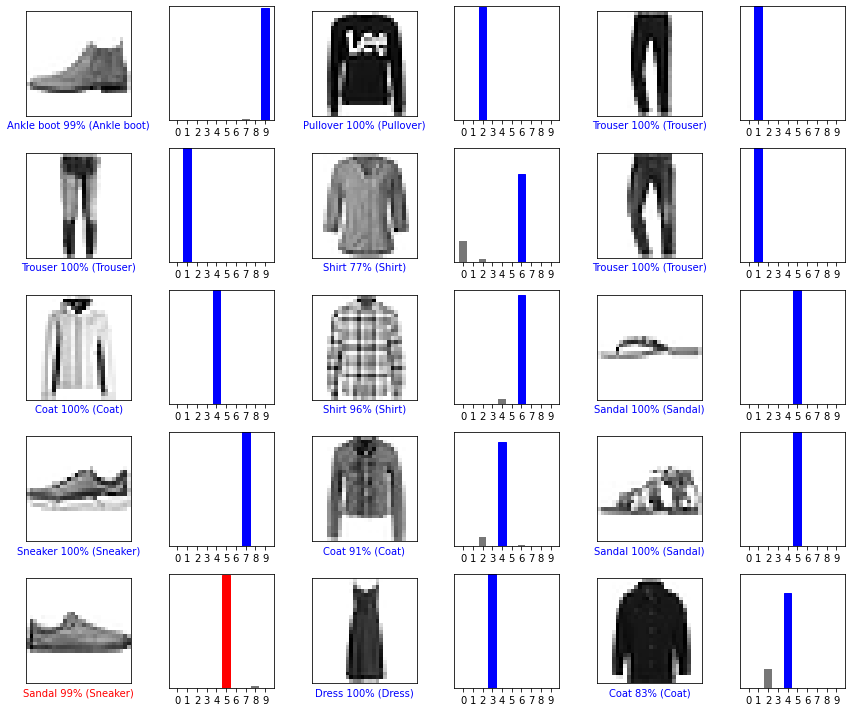

In [6]:
classification_2a = Classification(train_fashion_images, train_fashion_labels,
                                  test_fashion_images, test_fashion_labels, add_layer=True)
classification_2a()

### (b) Changing the activation function

#### (i) Sigmoid

Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5381 - accuracy: 0.8150
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3904 - accuracy: 0.8590
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3539 - accuracy: 0.8712
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3310 - accuracy: 0.8801
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3122 - accuracy: 0.8860
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2974 - accuracy: 0.8914
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2837 - accuracy: 0.8960
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2719 - accuracy: 0.8997
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2620 - accuracy: 0.9036
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.252

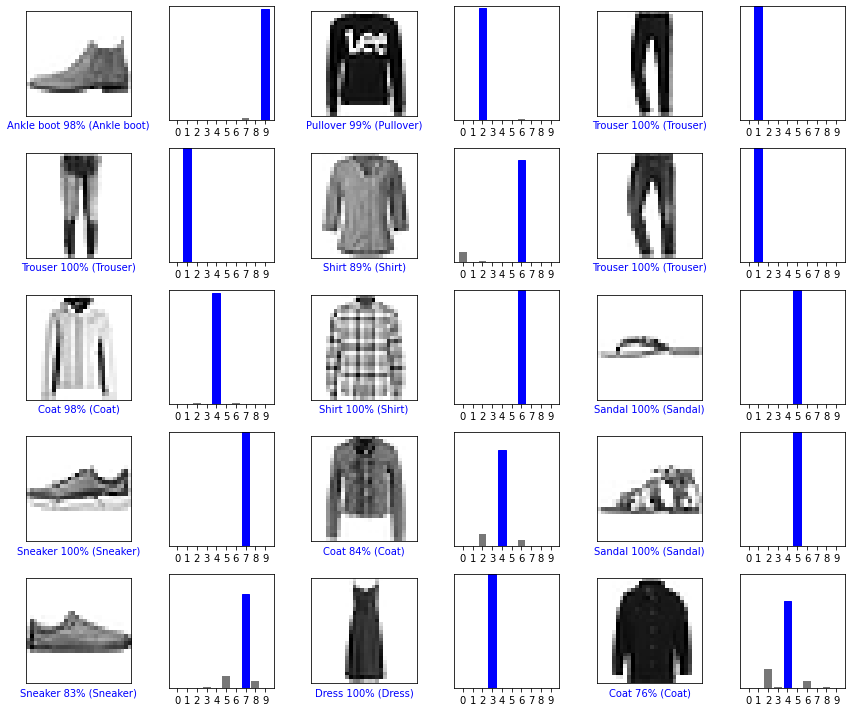

In [7]:
classification_2bi = Classification(train_fashion_images, train_fashion_labels,
                                  test_fashion_images, test_fashion_labels, activation='sigmoid')
classification_2bi()

#### (ii) Exponential

Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4927 - accuracy: 0.8237
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3920 - accuracy: 0.8600
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3646 - accuracy: 0.8719
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3493 - accuracy: 0.8755
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3418 - accuracy: 0.8787
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3306 - accuracy: 0.8827
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3093 - accuracy: 0.8881
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3150 - accuracy: 0.8889
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3355 - accuracy: 0.8886
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.291

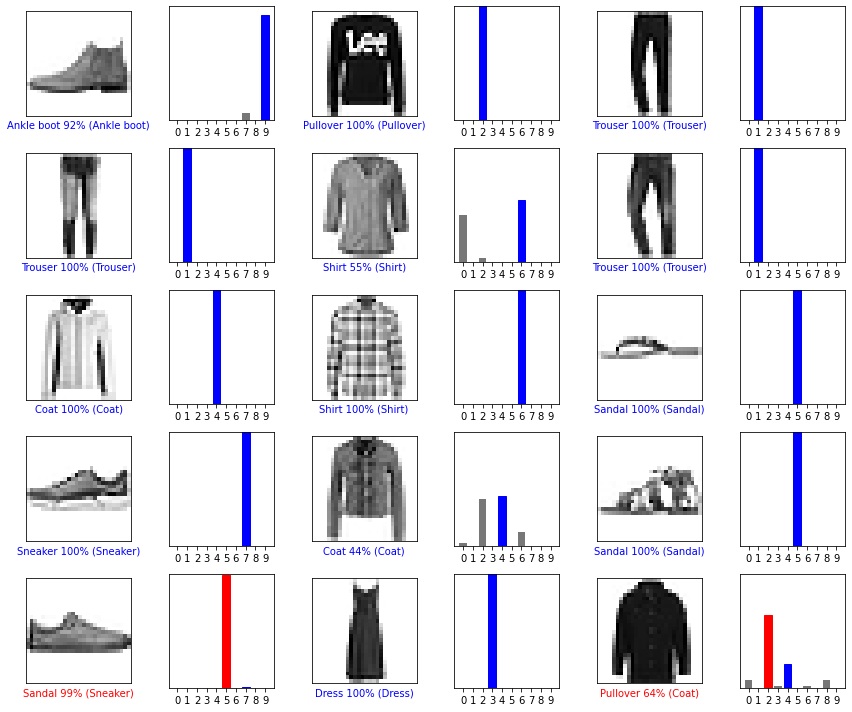

In [8]:
classification_2bii = Classification(train_fashion_images, train_fashion_labels,
                                  test_fashion_images, test_fashion_labels, activation='exponential')
classification_2bii()

### (c) Decreasing dense layer nodes

Epoch 1/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.5287 - accuracy: 0.8151
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3985 - accuracy: 0.8570
Epoch 3/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3629 - accuracy: 0.8692
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3381 - accuracy: 0.8761
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3214 - accuracy: 0.8824
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3068 - accuracy: 0.8884
Epoch 7/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2966 - accuracy: 0.8903
Epoch 8/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2866 - accuracy: 0.8957
Epoch 9/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2771 - accuracy: 0.8984
Epoch 10/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.270

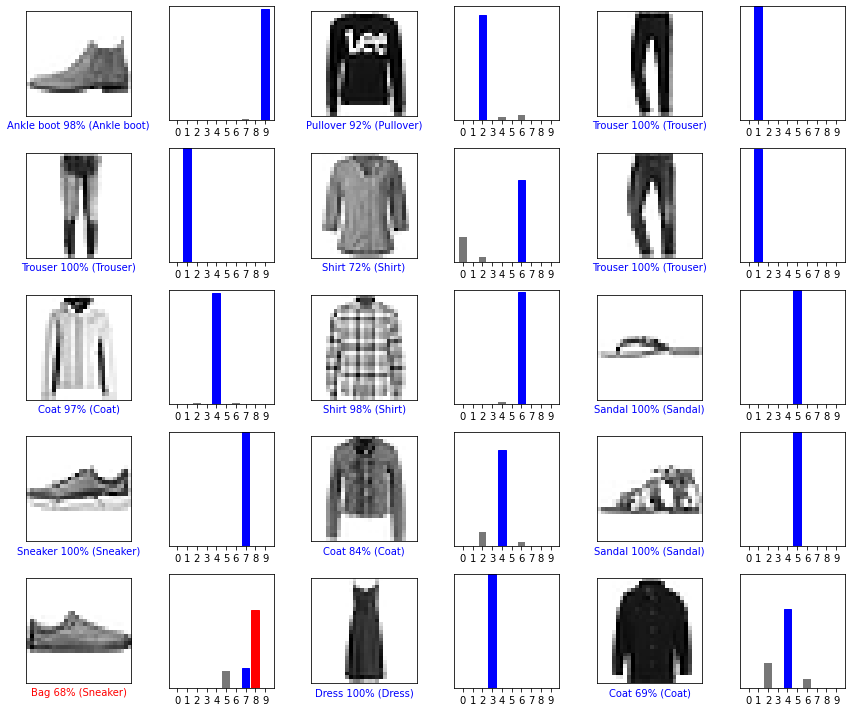

In [9]:
classification_2c = Classification(train_fashion_images, train_fashion_labels,
                                  test_fashion_images, test_fashion_labels, num_nodes1=64)
classification_2c()

## Comparison note

For this classification model, we tried three different variation methods, with five total models built. Starting off with the original network with no alterations, the model was able to get a 87.98& test accuracy. As for the display of predictions, it correctly and confidently classified every example except for the sneaker, for which it predicted sandal.

The next model is that with an additional layer. We added a dense layer with output dimension 64 and using the same activation function as the original layer. This model achieved a test accuracy of 87.82%, which is lower than that of the original model's, but by an insignificant and likely random amount. As for the display of predictions, it exhibited the same behavior as the original network, but incorrectly classified the sneaker with even more confidence. We could conclude from this experiment that adding just one additional dense layer does not aid the network in better learning the classification patterns.

For the next two models, we changed the activation function from ReLU to sigmoid and exponential. The sigmoid model obtained a test accuracy of 87.93%, which is again lower than the original model but by an insignificant amount. This model was actually able to classify every example in the display correctly, even the sneaker image that the previous models struggled with. The exponential model had the worst performance with a test accuracy of 85.69%. This is again not that much lower than the original network's performance, but in terms of the small deviations of the other models, it could be considered significantly worse. The exponential model was not able to correctly classify the sneaker image, and in addition wrongly predicted the coat image as a pullover. We could conclude from this experiment that the sigmoid activation function is as good if not better than the ReLU for this data (and that the exponential activation function is likely not a good choice).

The final variation is a model with a decreased number of nodes in its dense layer. The number of nodes in this fully connected layer was changed from 128 to 64, and the model resulted in a test accuracy of 87.53%. Once again, we see a very small change from the original model. This model also wrongly classified the sneaker, but instead of predicting "sandal" like the other models that got this image wrong, it predicted "bag." We could conclude from this experiment that even with a smaller dense layer, the network is still able to learn the data well.

# Problem 2: GAN

Play with the code: https://www.tensorflow.org/tutorials/generative/dcgan.

## (1)

Write a memo for the code, annotating some important lines that carry out key computations.

We first load the MNIST dataset. We will use 5,000 observations to improve training time. This will, however, result in a less powerful network.

In [10]:
(train_mnist_images, train_mnist_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_mnist_images = train_mnist_images.reshape(train_mnist_images.shape[0], 28, 28, 1).astype('float32')
train_mnist_images = (train_mnist_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

BUFFER_SIZE = 5000
BATCH_SIZE = 256

# Batch and shuffle the data, only 5000
train_dataset = tf.data.Dataset.from_tensor_slices(train_mnist_images[:5000]).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

11493376/11490434 [==============================] - 0s 0us/step


In [15]:
class GAN:
    """
    what it does

    Methods
    -------
    make_generator_model(self):
        Builds the generator model, which learns to create "fake" images that look real. The generator will generate
         handwritten digits resembling the MNIST data.
    make_discriminator_model(self):
        Builds the discriminator model, which learns to tell real images apart from fakes. It is a CNN-based image
         classifier. The model will be trained to output positive values for real images, and negative values for fake
          images.
    discriminator_loss(self, real_output, fake_output):
        This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares
         the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake
          (generated) images to an array of 0s.
    generator_loss(self, fake_output):
        The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator
         is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the
          discriminators decisions on the generated images to an array of 1s.
    train_step(self, images, generator, discriminator, generator_optimizer, discriminator_optimizer):
        Performs one step of training. Generator produces an image, discriminator classifies between reals and fakes,
         loss is computed for each model, then gradients are used to update each model.
    train(self, dataset, generator, discriminator, generator_optimizer, discriminator_optimizer):
        Uses train_step() method to iterate over dataset and learn generator+discriminator. Generates image after the
         final epoch.
    generate_and_save_images(model, epoch, test_input):
        Utility method to plot generator images.
    display_image(epoch_no):
        Display a single image using the epoch number.
    """

    def __init__(self, train_dataset, add_layers=False, epochs=50, noise_dim=100, num_examples_to_generate=16,
                 batch_size=256):
        """
        Constructs all necessary parameters for GAN object.
        :param train_dataset: properly shaped training dataset
        :param add_layers: whether or not to add a chunk of layers to both generator and discriminator models
        :param epochs: number of epochs for training
        :param noise_dim: dimension of noise variable
        :param num_examples_to_generate: number of examples to generate (for gif)
        :param batch_size: size of training batches
        """
        self.train_dataset = train_dataset
        self.add_layers = add_layers
        self.epochs = epochs
        self.noise_dim = noise_dim
        self.num_examples_to_generate = num_examples_to_generate
        self.batch_size = batch_size
        # This method returns a helper function to compute cross entropy loss
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        # We will reuse this seed overtime (so it's easier)
        # to visualize progress in the animated GIF
        self.seed = tf.random.normal([self.num_examples_to_generate, self.noise_dim])

    def __call__(self):
        """
        When called, the models are built and trained, then a resulting example is displayed.
        :return: nothing
        """
        generator = self.make_generator_model()
        discriminator = self.make_discriminator_model()
        generator_optimizer = tf.keras.optimizers.Adam(1e-4)
        discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.train(train_dataset, generator, discriminator, generator_optimizer, discriminator_optimizer)
        self.display_image(self.epochs)

    def make_generator_model(self):
        """
        Builds the generator model, which learns to create "fake" images that look real. The generator will generate
         handwritten digits resembling the MNIST data.
        :return: the generator model
        """
        model = tf.keras.Sequential()
        # dense layer takes random seed as input
        model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(self.noise_dim,)))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        model.add(layers.Reshape((7, 7, 256)))
        assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

        # upsampling layer to produce an image from a seed
        model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
        assert model.output_shape == (None, 7, 7, 128)
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        # upsample several times until reach the desired image size of 28x28x1
        model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
        assert model.output_shape == (None, 14, 14, 64)
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        if self.add_layers:
            model.add(layers.Conv2DTranspose(32, (5, 5), strides=(1, 1), padding='same', use_bias=False))
            assert model.output_shape == (None, 14, 14, 32)
            model.add(layers.BatchNormalization())
            model.add(layers.LeakyReLU())

        # output layer activation is tanh
        model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
        assert model.output_shape == (None, 28, 28, 1)

        return model

    def make_discriminator_model(self):
        """
        Builds the discriminator model, which learns to tell real images apart from fakes. It is a CNN-based image
         classifier. The model will be trained to output positive values for real images, and negative values for fake
          images.
        :return: the discriminator model
        """
        model = tf.keras.Sequential()
        model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                input_shape=[28, 28, 1]))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))

        model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))

        if self.add_layers:
            model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
            model.add(layers.LeakyReLU())
            model.add(layers.Dropout(0.3))

        model.add(layers.Flatten())
        model.add(layers.Dense(1))

        return model

    def discriminator_loss(self, real_output, fake_output):
        """
        This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares
         the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake
          (generated) images to an array of 0s.
        :param real_output: discriminator's predictions on real images
        :param fake_output: discriminator's predictions on fake (generated) images
        :return: sum cross-entropy of real predictions and fake predictions
        """
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, fake_output):
        """
        The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator
         is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the
          discriminators decisions on the generated images to an array of 1s.
        :param fake_output: discriminator's predictions on (generated) fake images
        :return: cross-entropy of fake predictions and array of 1s
        """
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    # Notice the use of `tf.function`
    # This annotation causes the function to be "compiled".
    @tf.function
    def train_step(self, images, generator, discriminator, generator_optimizer, discriminator_optimizer):
        """
        Performs one step of training. Generator produces an image, discriminator classifies between reals and fakes,
         loss is computed for each model, then gradients are used to update each model.
        :param images: images for one batch
        :param generator: current step generator
        :param discriminator: current step discriminator
        :param generator_optimizer: optimizer that updates the generator
        :param discriminator_optimizer: optimizer that updates the optimizer
        :return: nothing
        """
        noise = tf.random.normal([self.batch_size, self.noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # begins with generator receiving a random seed as input, produces an image
            generated_images = generator(noise, training=True)

            # discriminator is used to classify real images and fake images
            real_output = discriminator(images, training=True)
            fake_output = discriminator(generated_images, training=True)

            # loss is calculated for each of these models
            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        # gradients are used to update the generator and discriminator
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        return gen_loss, disc_loss

    def train(self, dataset, generator, discriminator, generator_optimizer, discriminator_optimizer):
        """
        Uses train_step() method to iterate over dataset and learn generator+discriminator. Generates image after the
         final epoch.
        :param dataset: training set
        :param generator: initialized generator
        :param discriminator: initialized discriminator
        :param generator_optimizer: optimizer that updates the generator
        :param discriminator_optimizer: optimizer that updates the discriminator
        :return: nothing
        """
        for epoch in range(self.epochs):
            print('Training epoch {}'.format(epoch + 1))
            start = time.time()
            for image_batch in dataset:
                gen_loss, disc_loss = self.train_step(image_batch, generator, discriminator, generator_optimizer,
                                                      discriminator_optimizer)

            # Produce images for the GIF as we go
            # display.clear_output(wait=True)
            # self.generate_and_save_images(generator,
            #                              epoch + 1,
            #                              self.seed)

            print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

        # Generate after the final epoch
        # display.clear_output(wait=True)
        # self.generate_and_save_images(generator,
        #                              self.epochs,
        #                              self.seed)
        print('Final Generator Loss: {}'.format(gen_loss))
        print('Final Discriminator Loss: {}'.format(disc_loss))

    @staticmethod
    def generate_and_save_images(model, epoch, test_input):
        """
        Utility method to plot generator images.
        :param model: generator model
        :param epoch: epoch num of image to plot
        :param test_input: input seed
        :return: nothing
        """
        # Notice `training` is set to False.
        # This is so all layers run in inference mode (batchnorm).
        predictions = model(test_input, training=False)

        fig = plt.figure(figsize=(4, 4))

        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i + 1)
            plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')

        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
        plt.show()

    @staticmethod
    def display_image(epoch_no):
        """
        Display a single image using the epoch number.
        :param epoch_no: epoch number
        :return: displayed image
        """
        return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [16]:
gan_1 = GAN(train_dataset, epochs=10)
gan_1()

Training epoch 1
Time for epoch 1 is 56.481582164764404 sec
Training epoch 2
Time for epoch 2 is 54.804099798202515 sec
Training epoch 3
Time for epoch 3 is 54.88567924499512 sec
Training epoch 4
Time for epoch 4 is 55.118486166000366 sec
Training epoch 5
Time for epoch 5 is 55.184478521347046 sec
Training epoch 6
Time for epoch 6 is 55.66741681098938 sec
Training epoch 7
Time for epoch 7 is 54.822479009628296 sec
Training epoch 8
Time for epoch 8 is 55.44130492210388 sec
Training epoch 9
Time for epoch 9 is 57.22184443473816 sec
Training epoch 10
Time for epoch 10 is 54.69403576850891 sec
Final Generator Loss: 0.7592910528182983
Final Discriminator Loss: 1.1989145278930664


## (2)

Vary the model architecture, e.g., adding a layer, changing the number of channels in CNN, or the dimension of the hidden vector in RNN, and report the results.

In this section, we'll experiment with adding a chunk of layers to both the generator and discriminator models. In the generator model, convolutional, batch normalization, and leaky ReLU layers are added. In the discriminator model, convolutional, leaky ReLU, and dropout layers are added.

### (a) Add layers

In [17]:
gan_2a = GAN(train_dataset, add_layers=True, epochs=10)
gan_2a()

Training epoch 1
Time for epoch 1 is 71.83643794059753 sec
Training epoch 2
Time for epoch 2 is 70.02463221549988 sec
Training epoch 3
Time for epoch 3 is 70.12102675437927 sec
Training epoch 4
Time for epoch 4 is 69.75913715362549 sec
Training epoch 5
Time for epoch 5 is 69.87794160842896 sec
Training epoch 6
Time for epoch 6 is 69.7907497882843 sec
Training epoch 7
Time for epoch 7 is 69.60978937149048 sec
Training epoch 8
Time for epoch 8 is 69.53872799873352 sec
Training epoch 9
Time for epoch 9 is 69.66028261184692 sec
Training epoch 10
Time for epoch 10 is 69.93929672241211 sec
Final Generator Loss: 1.1400641202926636
Final Discriminator Loss: 0.7332655191421509


## Comparison note

The aspect of the model architecture that was varied in this problem was the number of layers. In the variation, we added a chunk of layers to both the generator and discriminator models. To the generator model, we added a convolutional, batch normalization, and leaky ReLU layer. To the discriminator model, we added a convolutional, leaky ReLU, and dropout layer. 

The results were quite interesting; in the original model, we can see that after 10 training epochs we obtained a final generator loss of 0.7593 and a final discriminator loss of 1.1989. However, after adding the layer chunks to both models, we find that the loss values almost switch: the final generator loss is 1.1401, and the final discriminator loss is 0.7333. We could conclude from this result that the layer chunk that was added to the discriminator model was beneficial, while that added to the generator model was not (perhaps due to overparameterization).

# Problem 3: Translation

Play with the code: https://www.tensorflow.org/tutorials/text/nmt_with_attention.

## (1)

Write a memo for the code, annotating some important lines that carry out key computations.

In [14]:
# Download the file
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip) + "/spa-eng/spa.txt"

2646016/2638744 [==============================] - 0s 0us/step


In [18]:
class GetData:
    """
    Class for downloading and cleaning data.

    Methods
    -------
    unicode_to_ascii(s):
        Converts any unicode characters to ASCII.
    preprocess_sentence(self, w):
        Converts any unicode to ascii, creates a space between a word and the punctuation following it, replaces
         everything with space except (a-z, A-Z, ".", "?", "!", ","), and adds a start and an end token to the sentence.
    create_dataset(self, path, num_examples):
        Opens path to file, preprocesses all lines in file.
    tokenize(lang):
        Returns tokenizer for a specific language.
    load_dataset(self, num_examples=None):
        Creates dataset and tokenizes it.
    """

    def __init__(self, path_to_file):
        """
        Constructs necessary parameter for GetData.
        :param path_to_file: string of os path to data file
        """
        self.path_to_file = path_to_file

    def __call__(self):
        """
        Loads dataset and splits into training set.
        :return: input_tensor_train, target_tensor_train, max_length_targ, max_length_inp, inp_lang, targ_lang
        """
        # Try experimenting with the size of that dataset
        num_examples = 30000
        input_tensor, target_tensor, inp_lang, targ_lang = self.load_dataset(num_examples)

        # Calculate max_length of the target tensors
        max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

        # Creating training and validation sets using an 80-20 split
        input_tensor_train, _, target_tensor_train, _ = train_test_split(input_tensor, target_tensor, test_size=0.2)

        return input_tensor_train, target_tensor_train, max_length_targ, max_length_inp, inp_lang, targ_lang

    # Converts the unicode file to ascii
    @staticmethod
    def unicode_to_ascii(s):
        """
        Converts any unicode characters to ASCII.
        :param s: string to search
        :return: s with unicode replaced w/ ascii
        """
        return ''.join(c for c in unicodedata.normalize('NFD', s)
                       if unicodedata.category(c) != 'Mn')

    def preprocess_sentence(self, w):
        """
        Converts any unicode to ascii, creates a space between a word and the punctuation following it, replaces
         everything with space except (a-z, A-Z, ".", "?", "!", ","), and adds a start and an end token to the sentence.
        :param w: sentence to preprocess
        :return: cleaned sentence
        """
        w = self.unicode_to_ascii(w.lower().strip())

        # creating a space between a word and the punctuation following it
        # eg: "he is a boy." => "he is a boy ."
        w = re.sub(r"([?.!,¿])", r" \1 ", w)
        w = re.sub(r'[" "]+', " ", w)

        # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
        w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

        w = w.strip()

        # adding a start and an end token to the sentence
        # so that the model know when to start and stop predicting.
        w = '<start> ' + w + ' <end>'
        return w

    # 1. Remove the accents
    # 2. Clean the sentences
    # 3. Return word pairs in the format: [ENGLISH, SPANISH]
    def create_dataset(self, path, num_examples):
        """
        Opens path to file, preprocesses all lines in file.
        :param path: path to file
        :param num_examples: number of lines to read
        :return: word pairs
        """
        lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

        word_pairs = [[self.preprocess_sentence(w) for w in l.split('\t')] for l in lines[:num_examples]]

        return zip(*word_pairs)

    @staticmethod
    def tokenize(lang):
        """
        Returns tokenizer for a specific language.
        :param lang: which language
        :return: tensor, lang_tokenizer
        """
        lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
            filters='')
        lang_tokenizer.fit_on_texts(lang)

        tensor = lang_tokenizer.texts_to_sequences(lang)

        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                               padding='post')

        return tensor, lang_tokenizer

    def load_dataset(self, num_examples=None):
        """
        Creates dataset and tokenizes it.
        :param num_examples: number of lines to read
        :return: input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer
        """
        # creating cleaned input, output pairs
        targ_lang, inp_lang = self.create_dataset(self.path_to_file, num_examples)

        input_tensor, inp_lang_tokenizer = self.tokenize(inp_lang)
        target_tensor, targ_lang_tokenizer = self.tokenize(targ_lang)

        return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer


class Encoder(tf.keras.Model, ABC):
    """
    Builds the encoder part of the model. The encoder is applied to the source language. It is an RNN that uses zero
     vectors as its starting states. The encoder is used to build a "thought" vector, a sequence of numbers that
      represents the sentence meaning.
    Methods
    -------
    """

    def __init__(self, vocab_size, embedding_dim=256, enc_units=1024, batch_size=64):
        """
        Constructs necessary parameters for Encoder.
        :param vocab_size: size of vocabulary.
        :param embedding_dim: dimension of layer embedding
        :param enc_units: dimension of output space
        :param batch_size: size of each training batch
        """
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def __call__(self, x, hidden):
        """
        Performs building of encoder.
        :param x: input
        :param hidden: encoder hidden layer
        :return: output, state
        """
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state

    def initialize_hidden_state(self):
        """
        Initializes hidden state
        :return: vector of zeros
        """
        return tf.zeros((self.batch_size, self.enc_units))


class BahdanauAttention(tf.keras.layers.Layer):
    """
    Implements attention mechanism which establishes direct short-cut connections between the target and the source by
     paying attention to relevant source content as we translate. Returns context_vector, attention_weights. Inherits
     keras layer.
    """

    def __init__(self, units):
        """
        Constructs necessary parameters for BahdanauAttention.
        :param units: num units for dense layers
        """
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def __call__(self, query, values):
        """
        Broadcasts addition along the time axis, calculates the score, computes attention_weights, computes context
         vector.
        :param query: inputted hidden layer
        :param values: encoder output
        :return: context_vector, attention_weights
        """
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


class Decoder(tf.keras.Model, ABC):
    """
    Builds the decoder of the model. The decoder processes the sentence vector to emit a translation. It is an RNN. It
     processes the target sentence while predicting the next words.
    """

    def __init__(self, vocab_size, embedding_dim=256, dec_units=1024, batch_size=64):
        """
        Constructs necessary parameters for Decoder.
        :param vocab_size: size of vocabulary
        :param embedding_dim: dimension of embedding layer
        :param dec_units: dimension of output space
        :param batch_size: size of training batch
        """
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def __call__(self, x, hidden, enc_output):
        """
        Gets context vector and attention weights, passes input through embedding, passes concatenated vector to the
         GRU, and passes it through dense layer.
        :param x: decoder input
        :param hidden: decoder hidden layer
        :param enc_output: encoder output
        :return: decoded x, state, attention_weights
        """
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights


class Translation:
    """
    Trains a sequence to sequence model for Spanish to English translation.

    Methods
    -------
    loss_function(self, real, pred):
        Provides sparse categorical cross-entropy loss given target and predictions.
    train_step(self, inp, targ, enc_hidden):
        Performs single step of training. Gets encoder output and hidden layer, feeds target as the next input, passes
         encoder output to decoder, computes loss, then updates optimizer with gradients.
    train(self):
        Performs entire training of encoder-decoder model.
    evaluate(self, sentence):
        Similar to the training loop, except we don't use teacher forcing here. The input to the decoder at each time
         step is its previous predictions along with the hidden state and the encoder output.
    plot_attention(attention, sentence, predicted_sentence):
        Utility function that plots the attention weights.
    translate(self, sentence):
        Translates a sentence from target to source and plots attention plot.
    """

    def __init__(self, path_to_file, train_size=5000, epochs=10, units=1024, batch_size=64):
        """
        Constructs necessary parameters for Translation.
        :param path_to_file:
        :param train_size: number of examples to train on
        :param epochs: number of training epochs
        :param units: dim of hidden layer
        :param batch_size: size of training batches
        """
        # get data
        get_data = GetData(path_to_file)
        input_tensor_train, target_tensor_train, self.max_length_targ, \
        self.max_length_inp, self.inp_lang, self.targ_lang = get_data()

        input_tensor_train = input_tensor_train[:train_size]
        target_tensor_train = target_tensor_train[:train_size]

        buffer_size = len(input_tensor_train)
        self.batch_size = batch_size
        self.steps_per_epoch = len(input_tensor_train) // self.batch_size
        self.vocab_inp_size = len(self.inp_lang.word_index) + 1
        self.vocab_tar_size = len(self.targ_lang.word_index) + 1

        dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(buffer_size)
        self.dataset = dataset.batch(self.batch_size, drop_remainder=True)
        # training params
        self.epochs = epochs
        self.units = units
        # initialize models
        self.encoder = Encoder(self.vocab_inp_size, enc_units=self.units)
        self.decoder = Decoder(self.vocab_tar_size, dec_units=self.units)
        # optimizer and loss
        self.optimizer = tf.keras.optimizers.Adam()
        self.loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

    def loss_function(self, real, pred):
        """
        Provides sparse categorical cross-entropy loss given target and predictions.
        :param real: true target
        :param pred: predictions
        :return: loss
        """
        mask = tf.math.logical_not(tf.math.equal(real, 0))
        loss_ = self.loss_object(real, pred)

        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask

        return tf.reduce_mean(loss_)

    @tf.function
    def train_step(self, inp, targ, enc_hidden):
        """
        Performs single step of training. Gets encoder output and hidden layer, feeds target as the next input, passes
         encoder output to decoder, computes loss, then updates optimizer with gradients.
        :param inp: example from dataset
        :param targ: true target
        :param enc_hidden: encoder hidden layer
        :return: batch loss
        """
        loss = 0

        with tf.GradientTape() as tape:
            # pass the input through the encoder, which returns encoder output and encoder hidden state
            enc_output, enc_hidden = self.encoder(inp, enc_hidden)

            dec_hidden = enc_hidden

            dec_input = tf.expand_dims([self.targ_lang.word_index['<start>']] * self.batch_size, 1)

            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder, returns predictions and decoder hidden state
                predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)

                loss += self.loss_function(targ[:, t], predictions)

                # using teacher forcing to decide the next input to the decoder
                dec_input = tf.expand_dims(targ[:, t], 1)

        batch_loss = (loss / int(targ.shape[1]))

        variables = self.encoder.trainable_variables + self.decoder.trainable_variables

        # calculate the gradients
        gradients = tape.gradient(loss, variables)

        # apply gradients to optimizer and backpropagate
        self.optimizer.apply_gradients(zip(gradients, variables))

        return batch_loss

    def train(self):
        """
        Performs entire training of encoder-decoder model.
        :return: none
        """
        for epoch in range(self.epochs):
            start = time.time()

            enc_hidden = self.encoder.initialize_hidden_state()
            total_loss = 0

            for (batch, (inp, targ)) in enumerate(self.dataset.take(self.steps_per_epoch)):
                batch_loss = self.train_step(inp, targ, enc_hidden)
                total_loss += batch_loss

                if batch % 10 == 0:
                    print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                                 batch,
                                                                 batch_loss.numpy()))

            print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                                total_loss / self.steps_per_epoch))
            print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

    def evaluate(self, sentence):
        """
        Similar to the training loop, except we don't use teacher forcing here. The input to the decoder at each time
         step is its previous predictions along with the hidden state and the encoder output.
        :param sentence:
        :return:
        """
        data_gen = GetData(path_to_file)
        attention_plot = np.zeros((self.max_length_targ, self.max_length_inp))

        sentence = data_gen.preprocess_sentence(sentence)

        inputs = [self.inp_lang.word_index[i] for i in sentence.split(' ')]
        inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                               maxlen=self.max_length_inp,
                                                               padding='post')
        inputs = tf.convert_to_tensor(inputs)

        result = ''

        hidden = [tf.zeros((1, self.units))]
        enc_out, enc_hidden = self.encoder(inputs, hidden)

        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([self.targ_lang.word_index['<start>']], 0)

        for t in range(self.max_length_targ):
            predictions, dec_hidden, attention_weights = self.decoder(dec_input,
                                                                      dec_hidden,
                                                                      enc_out)

            # storing the attention weights to plot later on
            attention_weights = tf.reshape(attention_weights, (-1,))
            # store the attention weights for every time step
            attention_plot[t] = attention_weights.numpy()

            predicted_id = tf.argmax(predictions[0]).numpy()

            result += self.targ_lang.index_word[predicted_id] + ' '

            # stop predicting when the model predicts the end token
            if self.targ_lang.index_word[predicted_id] == '<end>':
                return result, sentence, attention_plot

            # the predicted ID is fed back into the model
            dec_input = tf.expand_dims([predicted_id], 0)

        return result, sentence, attention_plot

    # function for plotting the attention weights
    @staticmethod
    def plot_attention(attention, sentence, predicted_sentence):
        """
        Utility function that plots the attention weights.
        :param attention: attention weights
        :param sentence: true sentence
        :param predicted_sentence: predicted sentence
        :return: plot
        """
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(1, 1, 1)
        ax.matshow(attention, cmap='viridis')

        fontdict = {'fontsize': 14}

        ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
        ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

        plt.show()

    def translate(self, sentence):
        """
        Translates a sentence from target to source and plots attention plot.
        :param sentence: sentence to translate
        :return: translated sentence and attention plot
        """
        result, sentence, attention_plot = self.evaluate(sentence)

        print('Input: %s' % sentence)
        print('Predicted translation: {}'.format(result))

        attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
        self.plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [19]:
translator_1 = Translation(path_to_file, epochs=5)
translator_1.train()

Epoch 1 Batch 0 Loss 4.4697
Epoch 1 Batch 10 Loss 3.0475
Epoch 1 Batch 20 Loss 2.8409
Epoch 1 Batch 30 Loss 2.5689
Epoch 1 Batch 40 Loss 2.4239
Epoch 1 Batch 50 Loss 2.2984
Epoch 1 Batch 60 Loss 2.1904
Epoch 1 Batch 70 Loss 2.2893
Epoch 1 Loss 2.6520
Time taken for 1 epoch 272.48030614852905 sec

Epoch 2 Batch 0 Loss 2.1635
Epoch 2 Batch 10 Loss 2.0440
Epoch 2 Batch 20 Loss 2.2219
Epoch 2 Batch 30 Loss 1.9563
Epoch 2 Batch 40 Loss 2.1832
Epoch 2 Batch 50 Loss 1.9334
Epoch 2 Batch 60 Loss 2.0130
Epoch 2 Batch 70 Loss 1.9857
Epoch 2 Loss 2.0606
Time taken for 1 epoch 260.8578541278839 sec

Epoch 3 Batch 0 Loss 1.9784
Epoch 3 Batch 10 Loss 1.7943
Epoch 3 Batch 20 Loss 1.8038
Epoch 3 Batch 30 Loss 1.9203
Epoch 3 Batch 40 Loss 1.9398
Epoch 3 Batch 50 Loss 1.8507
Epoch 3 Batch 60 Loss 1.8087
Epoch 3 Batch 70 Loss 1.5984
Epoch 3 Loss 1.7936
Time taken for 1 epoch 260.88646507263184 sec

Epoch 4 Batch 0 Loss 1.6007
Epoch 4 Batch 10 Loss 1.6052
Epoch 4 Batch 20 Loss 1.6047
Epoch 4 Batch 30 Loss

Input: <start> hace mucho frio aqui . <end>
Predicted translation: i can t be busy . <end> 


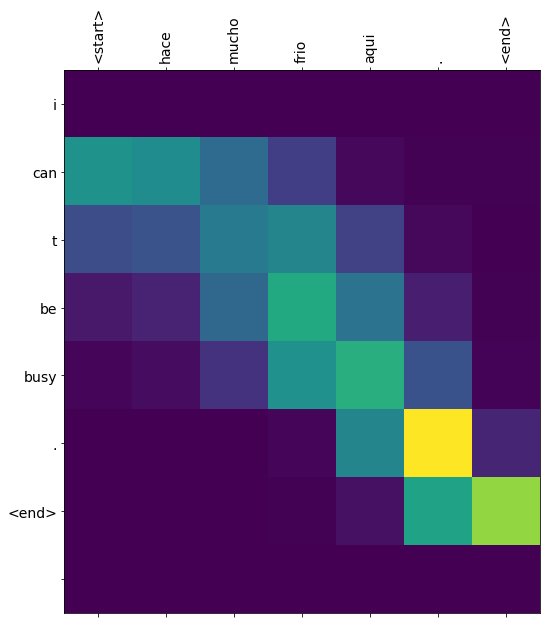

In [25]:
translator_1.translate(u'hace mucho frio aqui.')

## (2)

Vary the model architecture, e.g., adding a layer, changing the number of channels in CNN, or the dimension of the hidden vector in RNN, and report the results.

For the Translator model, we experiment with varying the dimension of the hidden layer. To do this, we will vary the `units` parameter in the initialization of the `Translator` object. This parameter will affect the dimensions of both the encoder and decoder hidden layers.

### (a) Decrease hidden layer dimension

In [26]:
translator_2a = Translation(path_to_file, epochs=5, units=512)
translator_2a.train()

Epoch 1 Batch 0 Loss 4.7832
Epoch 1 Batch 10 Loss 2.8053
Epoch 1 Batch 20 Loss 2.8297
Epoch 1 Batch 30 Loss 2.8166
Epoch 1 Batch 40 Loss 2.6921
Epoch 1 Batch 50 Loss 2.5777
Epoch 1 Batch 60 Loss 2.4759
Epoch 1 Batch 70 Loss 2.4692
Epoch 1 Loss 2.7906
Time taken for 1 epoch 78.65991640090942 sec

Epoch 2 Batch 0 Loss 2.3764
Epoch 2 Batch 10 Loss 2.2651
Epoch 2 Batch 20 Loss 2.3540
Epoch 2 Batch 30 Loss 2.3161
Epoch 2 Batch 40 Loss 2.1555
Epoch 2 Batch 50 Loss 2.1959
Epoch 2 Batch 60 Loss 2.2185
Epoch 2 Batch 70 Loss 2.0465
Epoch 2 Loss 2.2357
Time taken for 1 epoch 69.40820956230164 sec

Epoch 3 Batch 0 Loss 2.0842
Epoch 3 Batch 10 Loss 2.1155
Epoch 3 Batch 20 Loss 2.0909
Epoch 3 Batch 30 Loss 2.0595
Epoch 3 Batch 40 Loss 2.0981
Epoch 3 Batch 50 Loss 2.1596
Epoch 3 Batch 60 Loss 1.9991
Epoch 3 Batch 70 Loss 2.1093
Epoch 3 Loss 2.0630
Time taken for 1 epoch 69.53895235061646 sec

Epoch 4 Batch 0 Loss 1.8597
Epoch 4 Batch 10 Loss 1.9727
Epoch 4 Batch 20 Loss 1.8589
Epoch 4 Batch 30 Loss 1

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s a good . <end> 


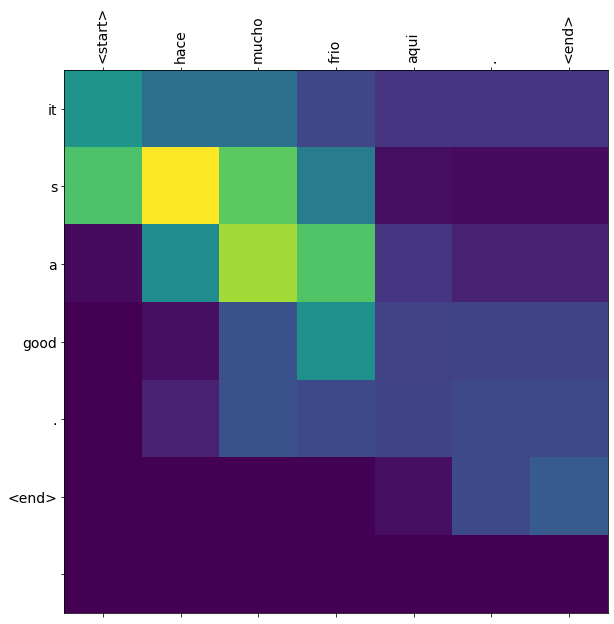

In [27]:
translator_2a.translate(u'hace mucho frio aqui.')

### (b) Increase hidden layer dimension

In [28]:
translator_2b = Translation(path_to_file, epochs=5, units=2048)
translator_2b.train()

Epoch 1 Batch 0 Loss 4.6873
Epoch 1 Batch 10 Loss 2.8945
Epoch 1 Batch 20 Loss 2.6467
Epoch 1 Batch 30 Loss 2.4588
Epoch 1 Batch 40 Loss 2.2879
Epoch 1 Batch 50 Loss 2.3198
Epoch 1 Batch 60 Loss 2.2869
Epoch 1 Batch 70 Loss 2.2782
Epoch 1 Loss 2.5955
Time taken for 1 epoch 934.4146797657013 sec

Epoch 2 Batch 0 Loss 2.0947
Epoch 2 Batch 10 Loss 2.0723
Epoch 2 Batch 20 Loss 1.8313
Epoch 2 Batch 30 Loss 1.9832
Epoch 2 Batch 40 Loss 1.9690
Epoch 2 Batch 50 Loss 1.9799
Epoch 2 Batch 60 Loss 1.8760
Epoch 2 Batch 70 Loss 1.7827
Epoch 2 Loss 1.9772
Time taken for 1 epoch 923.8946604728699 sec

Epoch 3 Batch 0 Loss 1.6498
Epoch 3 Batch 10 Loss 1.7298
Epoch 3 Batch 20 Loss 1.6281
Epoch 3 Batch 30 Loss 1.8405
Epoch 3 Batch 40 Loss 1.7673
Epoch 3 Batch 50 Loss 1.8223
Epoch 3 Batch 60 Loss 1.6873
Epoch 3 Batch 70 Loss 1.6503
Epoch 3 Loss 1.7315
Time taken for 1 epoch 925.2164349555969 sec

Epoch 4 Batch 0 Loss 1.5055
Epoch 4 Batch 10 Loss 1.5467
Epoch 4 Batch 20 Loss 1.5900
Epoch 4 Batch 30 Loss 1

Input: <start> hace mucho frio aqui . <end>
Predicted translation: you re too . <end> 


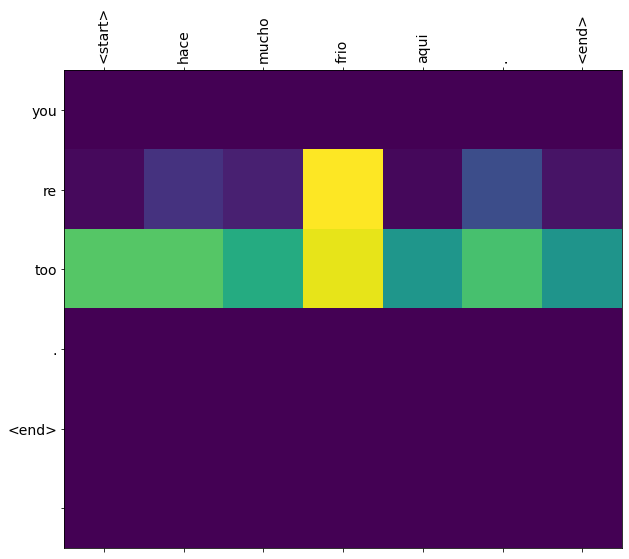

In [29]:
translator_2b.translate(u'hace mucho frio aqui.')

## Comparison note

To vary the model architecture of the Translator (encoder-decoder) model, we experiment with increasing and decreasing the dimensions of both the encoder and decoder hidden layers. The original model has a default dimension of 1024. After 5 training epochs, it achieves a loss of 1.4781. For the decreased dimension model, we halve the units (dimension) parameter to 512 and observe the results. The model with decreased hidden layer dimension achieves a loss of 1.7432. This is higher (worse) than the original model, which is likely due to underparameterization. To experiment with increased hidden layer dimension, we double the units parameter to 2048. The resulting model take significantly longer to train (about 13 times longer), but it sees a lower loss of 1.3998. Though this model slightly benefitted from having a higher dimension hidden layer, it is likely not worth the trade-off of such a long training time.

(The models trained are not able to accurately translate the example sentence from spanish to english, a direct result relating to the disclaimer at the beginning of this notebook.)